# Core 7.6 Feature Store - Transformations

In this section, we will take a look at the various ways you can transform data during ingestion using various engines.

### References

Much of the following content is derived from the official documenation:
- [Feature set transformations](https://docs.mlrun.org/en/stable/feature-store/transformations.html)

---

### What is a transformation and how are they applied?

In context of the Iguazio Feature Store, a transformation is simply a way of modifying or changing data during ingestion - either in batch or real-time. 

These transformations are added and applied by adding steps to a computation graph - exactly the same as in the `Real-Time Pipelines` module. In fact, we are using the same technology under the hood.

---

### What does a transformation look like?

A transformation will be a Python class or function that is added to the graph and executed during ingestion. The specific implementation of a transformation depends on the `engine` used, however they are all added the same way.

In general, you can describe transformations for each `engine` as follows:
- `storey`: Python class or function that receives an individual record as an `OrderedDict`, does something to the record, and outputs an `OrderedDict`
- `pandas`: Python class or function that receives an entire pandas dataframe, does something to the dataframe, and outputs the pandas dataframe
- `spark`: Python class or function that receives an entire spark dataframe, does something to the dataframe, and outputs the spark dataframe

---

### Transformation Example per Engine

#### Setup

In [1]:
import mlrun
import mlrun.feature_store as fstore
from mlrun.datastore.sources import DataFrameSource, CSVSource
import storey

import pandas as pd
from pyspark.sql import SparkSession
import pyspark.sql.functions as F

project = mlrun.get_or_create_project("iguazio-academy", context="./")

data = pd.read_csv("data/heart_disease_subset.csv")

data.head()

> 2022-04-28 22:35:42,163 [info] loaded project iguazio-academy from MLRun DB


,patient_id,oldpeak,chol,ca,exang
0,e443544b-8d9e-4f6c-9623-e24b6139aae0,1.0,212,2.0,no
1,8227d3df-16ab-4452-8ea5-99472362d982,3.1,203,0.0,yes
2,10c4b4ba-ab40-44de-8aba-6bdb062192c4,2.6,174,0.0,yes
3,f0acdc22-7ee6-4817-a671-e136211bc0a6,0.0,203,1.0,no
4,2d6b3bca-4841-4618-9a8c-ca902010b009,1.9,294,3.0,no


#### Storey Transformation

A `storey` transformation will be either a custom Python class that subclasses `storey.MapClass` or a simple Python function. The function approach is great for simpler transformations, whereas the class approach is great for more complex behaviors and passing parameters.

**Note that these transformations are designed to run on an invididual record. Even if a dataframe is ingested, each row will be processed separately.**

This is important to keep in mind for tasks like One Hot Encoding. Because you will only have an individual record at a time, all values to be One Hot Encoded need to be specified before ingestion.

In [2]:
def oldpeak_times_three_storey(event):
    """Simple transformation function to multiply oldpeak by 3"""
    event["three_x_oldpeak"] = event["oldpeak"] * 3
    return event

In [3]:
class MultiplyColumnsStorey(storey.MapClass):
    """
    Transformation class to create a new column based on
    multiplying other columns together.
    """
    def __init__(self, input_columns, output_column, **kwargs):
        super().__init__(**kwargs)
        self.input_columns = input_columns
        self.output_column = output_column

    def do(self, event):
        event[self.output_column] = 1
        for col in self.input_columns:
            event[self.output_column] *= event[col]
        return event

We will also use one of the build in steps - the [OneHotEncoder](https://github.com/mlrun/mlrun/blob/development/mlrun/feature_store/steps.py#L149)

In [4]:
from mlrun.feature_store.steps import OneHotEncoder

Once the transformations are defined, you can add them to the computation graph. When using a function, specify the `handler` parameter. When using a class, specify the `class_name` parameter. When using a class, you can also specify the `handler` to use (the default handler will be `do`).

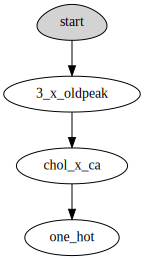

In [5]:
storey_set = fstore.FeatureSet(
    name="heart-disease-storey-transform",
    entities=[fstore.Entity("patient_id")],
    description="Heart disease data via storey engine with transformations",
    engine="storey"
)

storey_set.graph.to(name="3_x_oldpeak", handler="oldpeak_times_three_storey")\
                .to(name="chol_x_ca", class_name="MultiplyColumnsStorey", input_columns=["chol", "ca"], output_column="chol_x_ca")\
                .to(name="one_hot", class_name="OneHotEncoder", mapping={'exang': ['no', 'yes']})

storey_set.graph.plot()

Notice that the computation graph, classes, functions, and parameters are all stored within the `Feature Set`. This means that we can ingest the data just like before:

In [6]:
fstore.ingest(featureset=storey_set, source=DataFrameSource(df=data))

,oldpeak,chol,ca,exang_no,exang_yes,three_x_oldpeak,chol_x_ca
patient_id,,,,,,,
e443544b-8d9e-4f6c-9623-e24b6139aae0,1.0,212,2.0,1,0,3.0,424.0
8227d3df-16ab-4452-8ea5-99472362d982,3.1,203,0.0,0,1,9.3,0.0
10c4b4ba-ab40-44de-8aba-6bdb062192c4,2.6,174,0.0,0,1,7.8,0.0
f0acdc22-7ee6-4817-a671-e136211bc0a6,0.0,203,1.0,1,0,0.0,203.0
2d6b3bca-4841-4618-9a8c-ca902010b009,1.9,294,3.0,1,0,5.7,882.0
...,...,...,...,...,...,...,...
5d2fc80f-ed64-4e1c-9c95-3baace09118b,0.0,221,0.0,0,1,0.0,0.0
01548a7e-0f68-4308-80de-cd93fdbfb903,2.8,258,1.0,0,1,8.4,258.0
f8c97cc1-8a3a-4b8e-965c-58e75c2379e6,1.0,275,1.0,0,1,3.0,275.0


#### Pandas Transformation

A `pandas` transformation will be either a custom Python class a simple Python function. Like the `storey` engine, the function approach is great for simpler transformations, whereas the class approach is great for more complex behaviors and passing parameters.

**Note that these transformations are designed to run on an entire dataframe at once.**

Because you have access to the entire dataframe during the transformation, tasks like One Hot Encoding and imputing can be performed like you would expect.

In [7]:
def oldpeak_times_three_pandas(df):
    """Simple transformation function to multiply oldpeak by 3"""
    df["three_x_oldpeak"] = df["oldpeak"] * 3
    return df

In [8]:
class MultiplyColumnsPandas:
    """
    Transformation class to create a new column based on
    multiplying other columns together.
    """
    def __init__(self, input_columns, output_column):
        self.input_columns = input_columns
        self.output_column = output_column

    def custom_handler(self, df, context=None):
        df[self.output_column] = 1
        for col in self.input_columns:
            df[self.output_column] *= df[col]
        return df

In [9]:
class OneHotEncoderPandas:
    """
    One hot encoder using pandas get_dummies
    """
    def __init__(self, one_hot_columns):
        self.one_hot_columns = one_hot_columns
    
    def do(self, df, context=None):
        return pd.get_dummies(df, columns=self.one_hot_columns)

Once the transformations are defined, you can add them to the computation graph. When using a function, specify the `handler` parameter. When using a class, specify the `class_name` parameter. When using a class, you can also specify the `handler` to use (the default will be `do()`).

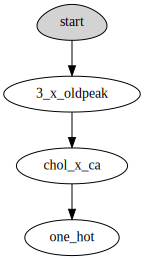

In [10]:
pandas_set = fstore.FeatureSet(
    name="heart-disease-pandas-transform",
    entities=[fstore.Entity("patient_id")],
    description="Heart disease data via pandas engine with transformations",
    engine="pandas"
)

pandas_set.graph.to(name="3_x_oldpeak", handler="oldpeak_times_three_pandas")\
                .to(name="chol_x_ca", class_name="MultiplyColumnsPandas", handler="custom_handler", input_columns=["chol", "ca"], output_column="chol_x_ca")\
                .to(name="one_hot", class_name="OneHotEncoderPandas", one_hot_columns=["exang"])

pandas_set.graph.plot()

For the sake of performance and not duplicating data in memory, the transformations will operate directly on the data passed in. If you are ingesting a dataframe, the original dataframe will be modified. To prevent this, pass in a copy (if memory allows) or a path to a file.

In this example, we will ingest a copy of the data to preserve the original.

In [11]:
fstore.ingest(featureset=pandas_set, source=DataFrameSource(df=data.copy()))

Warning - Server version '0.9.6' is different from client version '0.10.2'. Some operations may not work as expected.


,patient_id,oldpeak,chol,ca,three_x_oldpeak,chol_x_ca,exang_no,exang_yes
0,e443544b-8d9e-4f6c-9623-e24b6139aae0,1.0,212,2.0,3.0,424.0,1,0
1,8227d3df-16ab-4452-8ea5-99472362d982,3.1,203,0.0,9.3,0.0,0,1
2,10c4b4ba-ab40-44de-8aba-6bdb062192c4,2.6,174,0.0,7.8,0.0,0,1
3,f0acdc22-7ee6-4817-a671-e136211bc0a6,0.0,203,1.0,0.0,203.0,1,0
4,2d6b3bca-4841-4618-9a8c-ca902010b009,1.9,294,3.0,5.7,882.0,1,0
...,...,...,...,...,...,...,...,...
963,5d2fc80f-ed64-4e1c-9c95-3baace09118b,0.0,221,0.0,0.0,0.0,0,1
964,01548a7e-0f68-4308-80de-cd93fdbfb903,2.8,258,1.0,8.4,258.0,0,1
965,f8c97cc1-8a3a-4b8e-965c-58e75c2379e6,1.0,275,1.0,3.0,275.0,0,1
966,d7fc9e01-b792-44da-88fa-a0057527da3f,0.0,254,0.0,0.0,0.0,1,0


#### Spark Transformation

A `spark` transformation will be either a custom Python class a simple Python function. Like the `storey` and `pandas` engines, the function approach is great for simpler transformations, whereas the class approach is great for more complex behaviors and passing parameters.

**Note that these transformations are designed to run on an entire dataframe at once.**

Because you have access to the entire dataframe during the transformation, tasks like One Hot Encoding and imputing can be performed like you would expect.

In [12]:
def oldpeak_times_three_spark(df):
    """Simple transformation function to multiply oldpeak by 3"""
    return df.withColumn("three_x_oldpeak", df["oldpeak"] * 3)

In [13]:
class MultiplyColumnsSpark:
    """
    Transformation class to create a new column based on
    multiplying other columns together.
    """
    def __init__(self, input_columns, output_column):
        self.input_columns = input_columns
        self.output_column = output_column

    def custom_handler(self, df, context=None):
        df = df.withColumn(self.output_column, F.lit(1))
        for col in self.input_columns:
            df = df.withColumn(self.output_column, df[col] * df[self.output_column])
        return df

In [14]:
class OneHotEncoderSpark:
    """
    One hot encoder using spark in the same style as pandas get_dummies
    """
    def __init__(self, one_hot_columns):
        self.one_hot_columns = one_hot_columns
    
    def do(self, df, context=None):
        for one_hot_column in self.one_hot_columns:
            # Get distinct categories as list
            categories = df.select(one_hot_column).distinct().collect()
            categories = [c[one_hot_column] for c in categories]
            
            # Create expression per category - 1 if category 0 otherwise
            exprs = [F.when(F.col(one_hot_column) == category, 1)\
                      .otherwise(0)\
                      .alias(one_hot_column) for category in categories]

            # Create columns via expressions
            for category, expr in zip(categories, exprs):
                df = df.withColumn(f"{one_hot_column}_{category}", expr)

        return df.drop(one_hot_column)

Once the transformations are defined, you can add them to the computation graph. When using a function, specify the `handler` parameter. When using a class, specify the `class_name` parameter. When using a class, you can also specify the `handler` to use (the default will be `do()`).

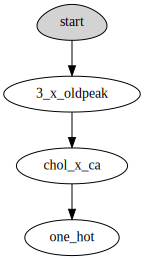

In [15]:
spark_set = fstore.FeatureSet(
    name="heart-disease-spark-transform",
    entities=[fstore.Entity("patient_id")],
    description="Heart disease data via spark engine with transformations",
    engine="spark"
)

spark_set.graph.to(name="3_x_oldpeak", handler="oldpeak_times_three_spark")\
                .to(name="chol_x_ca", class_name="MultiplyColumnsSpark", handler="custom_handler", input_columns=["chol", "ca"], output_column="chol_x_ca")\
                .to(name="one_hot", class_name="OneHotEncoderSpark", one_hot_columns=["exang"])

spark_set.graph.plot()

In [16]:
spark = SparkSession.builder.appName("Spark function").getOrCreate()

In [17]:
v3io_data_path = "v3io://users/nick/igz_repos/iguazio-academy/modules/core/7_feature_store/data/heart_disease_subset.csv"

In [18]:
fstore.ingest(featureset=spark_set, source=CSVSource(path=v3io_data_path), spark_context=spark)

> 2022-04-28 22:37:15,387 [info] writing to target parquet, spark options {'path': 'v3io://projects/iguazio-academy/FeatureStore/heart-disease-spark-transform/parquet/sets/heart-disease-spark-transform-latest', 'format': 'parquet'}
> 2022-04-28 22:37:16,897 [info] writing to target nosql, spark options {'path': 'v3io://projects/iguazio-academy/FeatureStore/heart-disease-spark-transform/nosql/sets/heart-disease-spark-transform-latest', 'format': 'io.iguaz.v3io.spark.sql.kv', 'key': 'patient_id'}


DataFrame[patient_id: string, oldpeak: double, chol: int, ca: double, three_x_oldpeak: double, chol_x_ca: double, exang_no: int, exang_yes: int]

---